In [15]:
import torch
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1]]
sns.set_palette('tab10')

root_path = "/home/yigit/projects/mbcnp/outputs/sine/"
test_names = ["1_sine", "2_sines", "3_sines", "4_sines"]
# test_names = ["1_sine", "2_sines", "3_sines", "4_sines", "8_sines"]

# root_path = "/home/yigit/projects/mbcnp/outputs/combined/large/"
# test_name = "diff_obs"

out_path = f'{root_path}comparison_all/'
if not os.path.exists(out_path):
    os.makedirs(out_path)

errors_and_losses = {}
all_num_tests = {}
test_id = 0

for test_path in [f'{root_path}{test_name}/' for test_name in test_names]:
    cnp_tls, cnp_ves, wta_tls, wta_ves = {}, {}, {}, {}
    num_tests = 0

    for suffix in os.listdir(test_path):
        if suffix.startswith('169'):
            d = os.path.join(test_path, suffix)
            if os.path.isdir(d):
                tl_code, ve_code = 'training_loss', 'validation_error'
                cnp_tl_path, cnp_ve_path = f'{d}/cnp_{tl_code}.pt', f'{d}/cnp_{ve_code}.pt'
                wta_tl_path, wta_ve_path = f'{d}/wta_{tl_code}.pt', f'{d}/wta_{ve_code}.pt'

                cnp_tl, cnp_ve = torch.load(cnp_tl_path, map_location=torch.device('cpu')), torch.load(cnp_ve_path, map_location=torch.device('cpu'))
                wta_tl, wta_ve = torch.load(wta_tl_path, map_location=torch.device('cpu')), torch.load(wta_ve_path, map_location=torch.device('cpu'))

                tl_size, ve_size = min(cnp_tl.shape[0], wta_tl.shape[0]), min(cnp_ve.shape[0], wta_ve.shape[0])
                # if tl_size < 500_000:
                #     continue

                cnp_tl, cnp_ve = cnp_tl[:tl_size], cnp_ve[:ve_size]
                wta_tl, wta_ve = wta_tl[:tl_size], wta_ve[:ve_size]

                cnp_tls.update({suffix:cnp_tl})
                cnp_ves.update({suffix:cnp_ve})
                wta_tls.update({suffix:wta_tl})
                wta_ves.update({suffix:wta_ve})
                num_tests += 1
    print(num_tests)
    errors_and_losses.update({test_names[test_id]: [cnp_tls, cnp_ves, wta_tls, wta_ves]})
    all_num_tests.update({test_names[test_id]:num_tests})
    test_id += 1
        

20
20
20
29


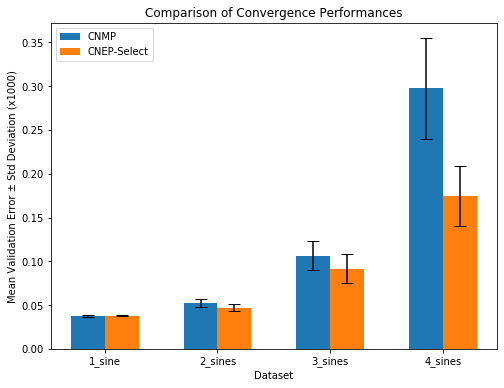

In [17]:
import numpy as np

models = ['CNMP', 'CNEP-Select']
ves = {}
ve_cnp, ve_wta, dev_cnp, dev_wta, err_cnp, err_wta = [], [], [], [], [], []

for err_key in errors_and_losses.keys():
    num_tests = all_num_tests[err_key]
    wta_ve_min, cnp_ve_min = np.zeros(num_tests), np.zeros(num_tests)

    cnp_ves, wta_ves = errors_and_losses[err_key][1], errors_and_losses[err_key][3]

    for i, key in enumerate(cnp_ves.keys()):
        cnp_ve_min[i] = cnp_ves[key].min()
        wta_ve_min[i] = wta_ves[key].min()

    # cnp_ve_min, wta_ve_min = np.array(cnp_ve_min), np.array(wta_ve_min)

    mean_errors = [np.mean(cnp_ve_min), np.mean(wta_ve_min)]
    std_dev = [np.std(cnp_ve_min), np.std(wta_ve_min)]  # Standard dev
    std_err = [np.std(cnp_ve_min)/np.sqrt(num_tests), np.std(wta_ve_min)/np.sqrt(num_tests)]  # Standard error

    ve_cnp.append(mean_errors[0]*1000)
    ve_wta.append(mean_errors[1]*1000)
    dev_cnp.append(std_dev[0]*1000)
    dev_wta.append(std_dev[1]*1000)
    err_cnp.append(std_err[0]*1000)
    err_wta.append(std_err[1]*1000)

    ves.update({err_key: [mean_errors, std_dev, std_err]})


barWidth = 0.3
br1 = np.arange(len(test_names))
br2 = [x + barWidth for x in br1]

plt.figure(figsize=(8, 6))

# for k in ves.keys():
plt.bar(br1, ve_cnp, yerr=dev_cnp, color=colors[0], width=barWidth, capsize=6)
plt.bar(br2, ve_wta, yerr=dev_wta, color=colors[1], width=barWidth, capsize=6)
 
# Adding Xticks
plt.xlabel('Dataset')
plt.ylabel('Mean Validation Error ± Std Deviation (x1000)')
plt.title('Comparison of Convergence Performances')

plt.xticks([r + 0.15 for r in range(len(test_names))], test_names)

plt.legend(labels=models)
# plt.show()


# plt.bar(models, mean_errors, yerr=std_dev, capsize=10, color=colors)
# plt.xlabel('Model')
# plt.ylabel('Mean of Minimum Validation Error ± Std Deviation')
# plt.title('Validation Error over Different Runs')

plt.savefig(f'{out_path}mean_min_ve.png')

# plt.close()



In [18]:
def mean_filter(x: torch.Tensor, window_size):
    return torch.nn.functional.avg_pool1d(x.unsqueeze(0), window_size, stride=1).squeeze(0)


def compare_and_plot(t0, t1, window_size=500, step=1000, index=0, is_tl=True, mean=False):
    # Comparing training losses
    t0_filtered, t1_filtered = mean_filter(t0, window_size), mean_filter(t1, window_size)

    tl_size = t0_filtered.shape[0]
    idx = torch.arange(start=0, end=tl_size, step=step)

    x = torch.arange(idx.shape[0])
    y1 = t0_filtered[idx]
    y2 = t1_filtered[idx]

    if is_tl:
        title = 'Training Loss'
        xlabel = f'Epoch / {step}'
        ylabel = 'NLL Loss'
        suffix = 'tl'
    else:
        title = 'Validation Error'
        ylabel = 'log(MSE)'
        suffix = 've'
        # xlabel = 'Epoch' if step == 1 else f'Epoch x {step}'
        xlabel = f'Epoch / {step*1000}'

    if mean:
        title = 'Mean ' + title

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(x, y1, '-', label='CNMP')
    plt.plot(x, y2, '-', label='CNEP-Select')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

    plt.savefig(f'{out_path}{index}_{suffix}.png')
    plt.close()


def plot_mean_std(t0, t1, s0, s1, window_size=500, step=1000):
    # Comparing training losses
    t0_filtered, t1_filtered = mean_filter(t0, window_size), mean_filter(t1, window_size)
    s0_filtered, s1_filtered = mean_filter(s0, window_size), mean_filter(s1, window_size)

    tl_size = t0_filtered.shape[0]
    idx = torch.arange(start=0, end=tl_size, step=step)

    x = torch.arange(idx.shape[0])
    y1 = t0_filtered[idx]
    y2 = t1_filtered[idx]
    e1, e2 = s0_filtered[idx], s1_filtered[idx]

    title = 'Mean Validation Error'
    ylabel = 'log(MSE)'
    suffix = 've'
    xlabel = f'Epoch / {step*1000}'

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(x, y1, '-', label='CNMP')
    plt.plot(x, y2, '-', label='CNEP-Select')
    plt.errorbar(x, y1, yerr=e1, color=colors[0], alpha=0.03)
    plt.errorbar(x, y2, yerr=e2, color=colors[1], alpha=0.03)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()

    plt.savefig(f'{out_path}{test_name}_mean_{suffix}.png')
    plt.close()

In [19]:
from tqdm import tqdm

for key in tqdm(cnp_tls):
    # print(cnp_tls[key].shape, wta_tls[key].shape)
    # compare_and_plot(cnp_tls[key][0, 100:], wta_tls[key][0, 100:], index=key, is_tl=True)

    # Comparing validation errors
    window_size=100
    step=1
    compare_and_plot(torch.log(cnp_ves[key]), torch.log(wta_ves[key]), window_size=window_size, step=step, index=key, is_tl=False)


100%|██████████| 29/29 [00:04<00:00,  7.11it/s]


NameError: name 'test_name' is not defined

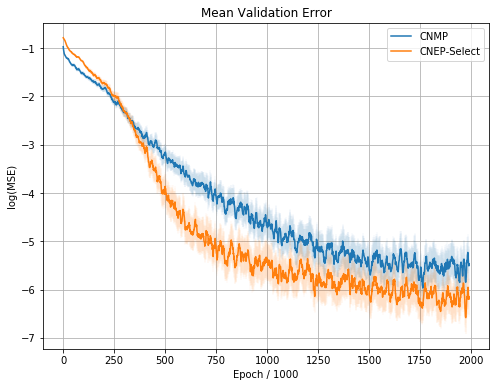

In [20]:
cnp_mean_ve, wta_mean_ve = torch.zeros(ve_size), torch.zeros(ve_size)
cnp_means, wta_means = torch.zeros(num_tests, ve_size), torch.zeros(num_tests, ve_size)

for i, key in enumerate(cnp_tls):
    cur_cnp_ve = torch.log(cnp_ves[key])
    cur_wta_ve = torch.log(wta_ves[key])
    # cnp_mean_tl += cnp_tls[key]
    # wta_mean_tl += wta_tls[key]
    cnp_mean_ve += cur_cnp_ve
    wta_mean_ve += cur_wta_ve
    cnp_means[i] = cur_cnp_ve
    wta_means[i] = cur_wta_ve

# cnp_mean_tl /= num_tests
cnp_mean_ve /= num_tests
# wta_mean_tl /= num_tests
wta_mean_ve /= num_tests

window_size=10
step=1

s0 = torch.std(cnp_means, dim=0) / torch.sqrt(torch.tensor(num_tests))  # Standard error
s1 = torch.std(wta_means, dim=0) / torch.sqrt(torch.tensor(num_tests))  # Standard error

plot_mean_std(cnp_mean_ve, wta_mean_ve, s0, s1, window_size, step)
